# Client Satisfaction

- Goal: The objective of the work are:
    - To reduce the number of columns of the dataset 
    - Predict insatisfied clients
- Framework: Pyspark
- Column to predict: "TARGET" where 0 represents a satisfied client and 1 insatisfied client

In [1]:
from pyspark import SparkContext

sc = SparkContext('local[*]', 'Santander_Client_Satisfaction_sc')
sc.setLogLevel('OFF')

22/11/04 10:54:30 WARN Utils: Your hostname, MacBook-Pro-de-Valentin.local resolves to a loopback address: 127.0.0.1; using 192.168.1.37 instead (on interface en0)
22/11/04 10:54:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/11/04 10:54:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName('Santander Client Satisfaction_ss').getOrCreate()
#spark.sparkContext.setLogLevel("OFF")
spark.conf.set("spark.sql.shuffle.partitions",2)

spark

## Functions

In [3]:

#Outlier detection and imputation by the mode
import pyspark.sql.functions as F

def outliers_detect(column):
    data.approxQuantile(column,[0.25,0.5,0.75],0.05)
    
    quantile = data.approxQuantile(column,[0.25,0.5,0.75],0.05)

    
    q1 = quantile[0]
    median = quantile[1]
    q3 = quantile[2]

    iqr = q3 - q1

    minimum = q1 - 1.5*iqr
    maximum = q3 + 1.5*iqr
    
    bounds = [minimum,median,maximum]
    return(bounds)

## Data

The data comes from the Santander bank that contains anonymous features about its customers that will be used to detect dissatisfied customers.

The data is already split in training and testing

In [4]:
#Testing data features
test = spark.read.csv('/Users/user/Desktop/Data Scientis R Python SQL/Datasets/Santander/test.csv',
                      header=True,
                      inferSchema=True)

#Testing target
test_target = spark.read.csv('/Users/user/Desktop/Data Scientis R Python SQL/Datasets/Santander/test_target.csv',
                      header=True,
                      inferSchema=True)

In [5]:
#Training data
data = spark.read.csv('/Users/user/Desktop/Data Scientis R Python SQL/Datasets/Santander/train.csv',
                     header=True,
                     inferSchema=True)

data.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- var3: integer (nullable = true)
 |-- var15: integer (nullable = true)
 |-- imp_ent_var16_ult1: double (nullable = true)
 |-- imp_op_var39_comer_ult1: double (nullable = true)
 |-- imp_op_var39_comer_ult3: double (nullable = true)
 |-- imp_op_var40_comer_ult1: double (nullable = true)
 |-- imp_op_var40_comer_ult3: double (nullable = true)
 |-- imp_op_var40_efect_ult1: double (nullable = true)
 |-- imp_op_var40_efect_ult3: double (nullable = true)
 |-- imp_op_var40_ult1: double (nullable = true)
 |-- imp_op_var41_comer_ult1: double (nullable = true)
 |-- imp_op_var41_comer_ult3: double (nullable = true)
 |-- imp_op_var41_efect_ult1: double (nullable = true)
 |-- imp_op_var41_efect_ult3: double (nullable = true)
 |-- imp_op_var41_ult1: double (nullable = true)
 |-- imp_op_var39_efect_ult1: double (nullable = true)
 |-- imp_op_var39_efect_ult3: double (nullable = true)
 |-- imp_op_var39_ult1: double (nullable = true)
 |-- imp_sal_var16_ult1: dou

## EDA

In [6]:
print(f' The dataset contains {len(data.columns)} columns and {data.count()} registers ')

 The dataset contains 371 columns and 60816 registers 


Given the data set is already partitioned the column ID is not necessary and will be removed

In [7]:
data = data.drop('ID')

It's important to check if there is any NULL or MISSING value in the dataset

In [8]:
null_values = data.select([F.count(F.when(F.col(c).contains('None') | \
                            F.col(c).contains('NULL') | \
                            F.col(c).contains('NaN') | \
                            (F.col(c) == '' ) | \
                            F.col(c).isNull() | \
                            F.isnan(c), c )).alias(c) for c in data.columns])


n_null = len(null_values.select([c for c in  null_values.columns if  null_values.collect()[0].asDict()[c]>0]).columns)

print(f"There are {n_null} columns with null values")

There are 0 columns with null values


### Duplicated data

The first step to reduce the data dimensions is to remove the duplicated data, if exist:

In [9]:
print(f' There are {data.count() - data.drop_duplicates().count()} duplicated registers')


 There are 3687 duplicated registers


The duplicated data are removed

In [10]:
data = data.dropDuplicates()

### Unvariant Columns

In the next code I will detect any column with null or low variance, given the columns without variance aren't good predictors 

In [11]:
# Remove constant variables

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

# Convert data to Vector
vectorAssembler = VectorAssembler(inputCols = data.drop('TARGET').columns, outputCol = 'features')
data_vector = vectorAssembler.transform(data).select('features','TARGET')

# Data Scaled 
scaler = MinMaxScaler(inputCol = 'features', outputCol = 'features_scaled')
scaler_model = scaler.fit(data_vector)

data_scaled = scaler_model.transform(data_vector).select('features_scaled','TARGET')

In [12]:
from pyspark.ml.feature import VarianceThresholdSelector

# The columns from the scaled data with a variance less than 0.001 will be removed
selector = VarianceThresholdSelector(featuresCol= 'features_scaled', outputCol = 'features_selected', varianceThreshold = 0.001)

selector_model = selector.fit(data_scaled)

#And the features selected are stored in the variable features_selected
features_selected = data.select(*[data.columns[c] for c in selector_model.selectedFeatures]).columns


In [13]:
print(f' There are {len(data.columns)-len(selector_model.selectedFeatures)} unvariant features')
print(f' The current dataset called data_selected contains {len(selector_model.selectedFeatures)} unvariant geatures')

 There are 260 unvariant features
 The current dataset called data_selected contains 110 unvariant geatures


Now I'am going to delete the unvariant columns from the dataset 

In [14]:
features_selected.append('TARGET')

data_selected = data[features_selected]

### Outliers imputation

The outliers could impact severely to the PCA and Logistic Regresion that I'll perform later, so them will be replace with the mode of each feature

In [15]:
for c in data_selected.drop('TARGET').columns:
    
    values = outliers_detect(c)
    
    minimum = values[0]
    maximum = values[2]
    
    median = values[1]
    
    data_selected = data_selected.withColumn(c,
                                             F.when(data_selected[c].between(minimum,maximum),
                                                    data_selected[c]).otherwise(F.lit(median)))
    

It's necessary to convert the dataframe into vector in order to perform the PCA. The data must be scaled

In [16]:
# Merge features into a Vector
vectorAssembler.setInputCols(data_selected.drop('TARGET').columns)
data_vector = vectorAssembler.transform(data_selected).select('features','TARGET')

# Data Scaled 
scaler = MinMaxScaler(inputCol = 'features', outputCol = 'features_scaled')
scaler_model = scaler.fit(data_vector)

data_scaled = scaler_model.transform(data_vector).select('features_scaled','TARGET')


The TARGET column is unbalanced, as we can see below:

In [17]:
data_scaled.select('TARGET').groupby('TARGET').count().show()

+------+-----+
|TARGET|count|
+------+-----+
|     0|54866|
|     1| 2263|
+------+-----+



Therefore, a weight column will be created to deal with it once the models are trained.

In [18]:
weigth = data_scaled.filter(F.col('TARGET') == 0).count()/data_scaled.count()

data_scaled = data_scaled.withColumn('weigth',F.when(data_scaled['TARGET'] == 0,1-weigth).otherwise(weigth))


Now it's time to perform the pca analysis in order to keep reducing the dimension of the training data. For that, it's necessary to pass the dataframe as vector, again.

The goal of the PCA is to reduce the number of columns, capturing most of its variability. I'll perform a pca with 10 components 

Text(0.5, 0, 'Cumulative Explained Variance')

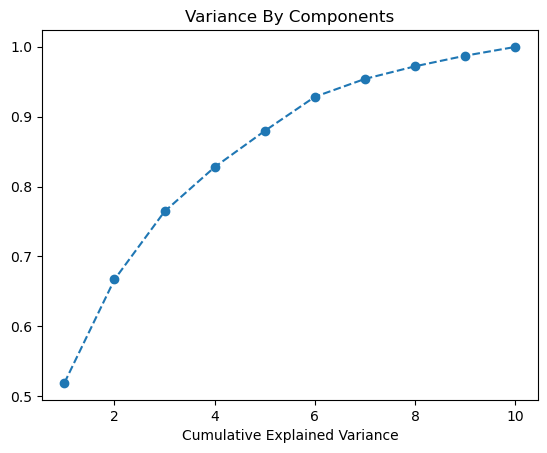

In [19]:
from pyspark.ml.feature import PCA

k_num = 10
#pca = PCA(k=k_num, inputCol="features", outputCol = 'features_pca')
pca = PCA(k=k_num, inputCol="features_scaled", outputCol = 'features_pca')
pca_model = pca.fit(data_scaled)


import matplotlib.pyplot as plt

plt.plot(range(1,k_num+1),pca_model.explainedVariance.values.cumsum(), marker = 'o', linestyle='--')
plt.title('Variance By Components')
plt.xlabel('Number of Components')
plt.xlabel('Cumulative Explained Variance')


In [20]:
import pandas as pd

pd.DataFrame({'k':range(1,k_num+1),
    '% of explained variance' :pca_model.explainedVariance.cumsum().round(4)})

,k,% of explained variance
0,1,0.5192
1,2,0.6671
2,3,0.7644
3,4,0.8278
4,5,0.8795
5,6,0.9283
6,7,0.9538
7,8,0.9719
8,9,0.9870
9,10,0.9995


In the above graphic, the rate of explained variance by adding a new component starts to decrease from the component 8. So I'll take 8 components which explain the 94.19% of the variability of the dataset

The new dataset with 8 components is called data_pca

In [21]:
k_num = 8

pca_model = pca.setK(k_num).fit(data_scaled)

data_pca = pca_model.transform(data_scaled).select('TARGET','features_pca', 'weigth')

## Models

The dataset is processed and ready to train a machine learning model to predict dissatisfied customers.

I will perform two models:
- Logistic Regresion 
- Random Forest

The models will be validated through a Cross Validation with 5 folds

The metrics to compare the models are:
- F1 Score
- AUC

### Logistic Regression

In [22]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.classification import LogisticRegression

#Lofistic Regression Model
lr_model = LogisticRegression(featuresCol = 'features_pca', labelCol='TARGET', weightCol = 'weigth')

#Evaluator
modelEvaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='TARGET')

#Param Grid
lr_paramGrid = ParamGridBuilder().addGrid(lr_model.maxIter, [50])\
                                 .addGrid(lr_model.fitIntercept, [True,False]) \
                                 .build()

#Cross Validator
lr_crossval = CrossValidator(estimator=lr_model,
                          estimatorParamMaps=lr_paramGrid,
                          evaluator=modelEvaluator,
                          numFolds=5)

#Model Training
lr_cvModel = lr_crossval.fit(data_pca)

### Random Forest

In [23]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#Random Forest Model
rf_model = RandomForestClassifier(featuresCol = 'features_pca',
                                  labelCol='TARGET',
                                  weightCol = 'weigth', 
                                  minInstancesPerNode = 20,
                                  bootstrap=True,
                                  subsamplingRate = 0.85,
                                  seed = 1234)

#Evaluator
modelEvaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='TARGET')

#Random Fores Param Grid
rf_paramGrid = ParamGridBuilder().addGrid(rf_model.numTrees, [400])\
                                 .addGrid(rf_model.maxDepth, [7])\
                                 .addGrid(rf_model.featureSubsetStrategy, ['sqrt'])\
                                 .build()
#Crossvalidator
rf_crossval = CrossValidator(estimator=rf_model,
                          estimatorParamMaps=rf_paramGrid,
                          evaluator=modelEvaluator,
                          numFolds=5)

#Random Forest Training Model
rf_cvModel = rf_crossval.fit(data_pca)

### F1 metric for training models

In [24]:
#Logistic Regression best model
lr_bestmodel = lr_cvModel.bestModel.summary

#Random Forest best model
rf_bestmodel = rf_cvModel.bestModel


{"F1 score for Logistic Regression": round(lr_bestmodel.weightedFMeasure(),2),
"F1 score for Random Forest": round(rf_bestmodel.summary.weightedFMeasure(),2)}


{'F1 score for Logistic Regression': 0.68, 'F1 score for Random Forest': 0.73}

### AUC and ROC

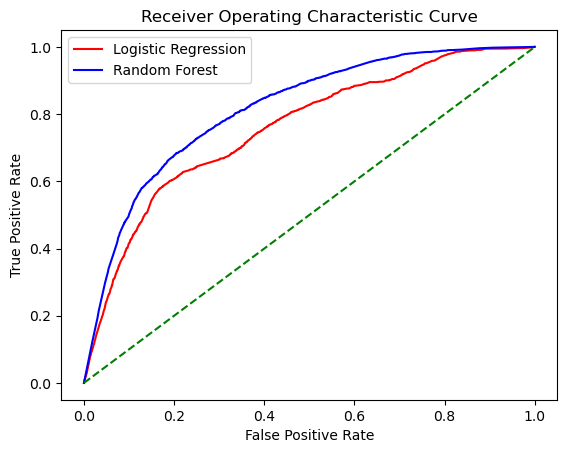

 Logistic Regression AUC: 0.76 
 Random Forest AUC: 0.82 


In [25]:
fpr_lr = lr_cvModel.bestModel.summary.roc.toPandas()['FPR']
tpr_lr = lr_cvModel.bestModel.summary.roc.toPandas()['TPR']

fpr_rf = rf_cvModel.bestModel.summary.roc.toPandas()['FPR']
tpr_rf = rf_cvModel.bestModel.summary.roc.toPandas()['TPR']

plt.plot(fpr_lr, tpr_lr, color='red', label='Logistic Regression')
plt.plot(fpr_rf, tpr_rf, color='blue', label='Random Forest')
plt.plot([0, 1], [0, 1], color='green', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend()
plt.show()


print(f' Logistic Regression AUC: {round(lr_cvModel.bestModel.summary.areaUnderROC,2)} ')
print(f' Random Forest AUC: {round(rf_cvModel.bestModel.summary.areaUnderROC,2)} ')

# Test processing

Since the training data has been preprocessed, it's time to replicate it in the testing data.

First of all, the testing data is splitted in two dataframes. So I'll add an index in both datafreme to join them

In [26]:
from pyspark.sql.window import Window

#Create an index column in both dataframes
test = test.withColumn("id",  F.row_number().over(Window.orderBy(F.monotonically_increasing_id())))
test_target = test_target.withColumn("id",  F.row_number().over(Window.orderBy(F.monotonically_increasing_id())))

In [27]:
#Join the dataframes
test = test.join(test_target, test.id ==test_target.id)

In [28]:
#The id Column is no longer needed
test = test.drop('id')

In [29]:
print(f' The testing dataframe contains {test.count()} registers')

 The testing dataframe contains 15204 registers


The same data processing on the training data will be applied to the test data.

In [30]:
from pyspark.sql.types import DoubleType

#Delete unvariant columns 
test = test[features_selected]

#Merge the features into a vector
test_vector = vectorAssembler.transform(test).select('features','TARGET')

#Scale the testing data
test_scaled = scaler_model.transform(test_vector).select('features_scaled','TARGET')

#Add weigth column
test_scaled = test_scaled.withColumn('weigth',F.when(test_scaled['TARGET'] == 0,1-weigth).otherwise(weigth))

#Transform testing data into a PCA 
test_pca = pca_model.transform(test_scaled).select('TARGET','features_pca', 'weigth')

#Cast prediction as Double 
test_pca = test_pca.withColumn("TARGET",F.col('TARGET').cast(DoubleType()))

### Predictions

In [31]:
#Logistic Regression prediction
lr_pred = lr_cvModel.bestModel.transform(test_pca)

#Random Forest prediction
rf_pred = rf_cvModel.bestModel.transform(test_pca)

### Evaluation

In [32]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(predictionCol = 'TARGET',labelCol = 'prediction', metricName = 'weightedFMeasure')


### F1 score for testing 

In [33]:
{ "Logistic Regression": round(evaluator.evaluate(lr_pred),2), 
              "Random Forest": round(evaluator.evaluate(rf_pred),2)}

{'Logistic Regression': 0.55, 'Random Forest': 0.79}

# Conclusion

We have reached the stated objective of reducing the number of predictors, starting from 340 and ending with 10 through different techniques in Pyspark. Regarding the models, the Random Forest model resulted with better F1 and AUC metrics than the Logistic Regression, although with not so satisfactory results. It is recommended to continue using different algorithms, such as XGBoost, which is not yet available in Pyspark.

In [34]:
sc.stop()
spark.stop()